In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import pennylane as qml
import pandas as pd

In [3]:
df = pd.read_csv('./dataset.csv')

In [4]:
n_train = 50

y_train = torch.tensor(df['nat_demand'].to_numpy()[:n_train]).to(torch.float)
x_train = torch.tensor(df[sorted("T2M_toc	QV2M_toc TQL_toc W2M_toc T2M_san QV2M_san TQL_san W2M_san T2M_dav QV2M_dav TQL_dav W2M_dav".split())].to_numpy()[:n_train]).to(torch.float)

xs = torch.tensor([(x_train[:,3 * i : 3 * i + 3].sum(dim=1)/3).tolist() for i in range(4)]).T
print(xs[1])
y_train = (y_train-y_train.min())/(y_train.max()-y_train.min())


tensor([1.7476e-02, 2.3959e+01, 3.5131e-02, 1.2807e+01])


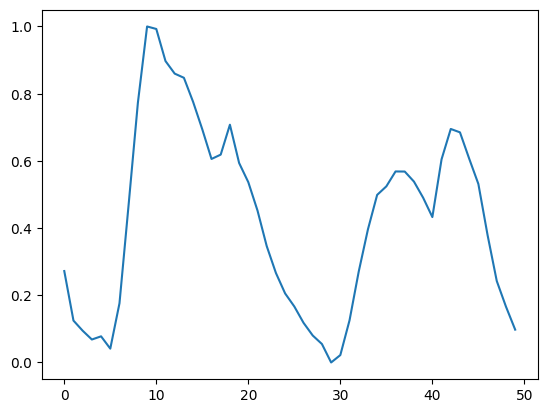

In [5]:
plt.plot(y_train)
plt.show()

In [6]:
temp = [i for i in range(12)]
temp_result = [sum(temp[3 * i : 3 * i + 3]) / 3 for i in range(4)]
print(temp_result)

[1.0, 4.0, 7.0, 10.0]


In [123]:
class G1(nn.Module):
    '''
    G for V(G)
    '''
    def __init__(self, input):
        super(G1, self).__init__()
        self.li1 = nn.Linear(input,16)
        self.li2 = nn.Linear(16, 16)
        self.li3 = nn.Linear(16, 2*input-1)
        
    def forward(self, x):
        x = self.li1(x)
        x = F.relu(x)
        x = self.li2(x)
        x = F.relu(x)
        x = self.li3(x)
        x = 2*torch.pi*F.relu(x)
        return x

In [124]:
n_qu = 4
dev = qml.device("default.qubit", wires = n_qu)

def embedding(params, n_qu):
    '''
    embedding layer
    '''
    n = n_qu
    for i in range(n):
        qml.Hadamard(i)
        qml.RZ(2.0 * params[:,i], i)
    
    for i in range(n - 1):
        qml.IsingZZ(2.0 * params[:,n + i] ,[i , i + 1])

@qml.qnode(dev, interface="torch")
def fidelity(vec1, vec2, n_qu):
    '''
        Args:
            vec1 : list, (2n - 1)개의 element로 이루어진 vector
            vec2 : list, (2n - 1)개의 element로 이루어진 vector
    '''
    embedding(vec1, n_qu) # Phi(x1) circuit 적용
    qml.adjoint(embedding)(vec2, n_qu) # Phi^t(x2) 적용
    return qml.probs()


In [125]:
class feature_train(nn.Module):
    def __init__(self,n_qu):
        super(feature_train, self).__init__()
        self.n_qu = n_qu
        self.linear1 = G1(input=n_qu)
        self.quantum_layer = fidelity
    def forward(self,input1,input2):
        input1 = self.linear1(input1)
        input2 = self.linear1(input2)
        output = self.quantum_layer(input1,input2,self.n_qu)[:,0]
        return output
        
        

In [141]:
epochs = 50

model = feature_train(n_qu)

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0005, betas=[0.9,0.999])

for epoch in range(epochs):
    optimizer.zero_grad()
    risk = 0
    f_loss_list = []

    for i in range(n_train-1):
        train_data = torch.stack([xs,torch.concat([xs[(i+1):],xs[:(i+1)]])])
        label_data = torch.stack([y_train,torch.concat([y_train[(i+1):],y_train[:(i+1)]])])
        f_loss = model(train_data[0],train_data[1])
        loss = -torch.sum((f_loss -(nn.Sigmoid()(label_data[0])-nn.Sigmoid()(label_data[1]))**2)**2)/n_train
        #print((label_data[0]-label_data[1])**2)
        #loss = -(loss**2)
        loss.backward()
    optimizer.step()
    print(f'epoch : {epoch}, risk : {loss}') if epoch%1==0 else None

epoch : 0, risk : -0.6482671499252319
epoch : 1, risk : -0.653384804725647
epoch : 2, risk : -0.6584529280662537
epoch : 3, risk : -0.665341317653656
epoch : 4, risk : -0.6707695722579956
epoch : 5, risk : -0.6764020323753357
epoch : 6, risk : -0.6821655035018921
epoch : 7, risk : -0.6845897436141968
epoch : 8, risk : -0.6868038177490234
epoch : 9, risk : -0.6885427832603455
epoch : 10, risk : -0.689517617225647
epoch : 11, risk : -0.690051794052124
epoch : 12, risk : -0.6907605528831482
epoch : 13, risk : -0.6914724111557007
epoch : 14, risk : -0.6923242807388306
epoch : 15, risk : -0.693970799446106
epoch : 16, risk : -0.6954250335693359
epoch : 17, risk : -0.6972097754478455
epoch : 18, risk : -0.6989204287528992
epoch : 19, risk : -0.7010671496391296
epoch : 20, risk : -0.7036150097846985
epoch : 21, risk : -0.7065166234970093
epoch : 22, risk : -0.7097094058990479
epoch : 23, risk : -0.7131173610687256
epoch : 24, risk : -0.7166568040847778
epoch : 25, risk : -0.7202395796775818
e

In [139]:
abs(label_data[0]-label_data[1])

tensor([1.7440e-01, 1.4744e-01, 3.0180e-02, 2.6146e-02, 9.4615e-03, 3.6638e-02,
        1.3499e-01, 2.9526e-01, 3.0147e-01, 2.2711e-01, 7.4114e-03, 9.5516e-02,
        3.7374e-02, 1.2405e-02, 7.1627e-02, 8.1867e-02, 8.8109e-02, 1.2917e-02,
        8.9005e-02, 1.1386e-01, 5.7232e-02, 8.4483e-02, 1.0567e-01, 8.0050e-02,
        6.0826e-02, 3.8874e-02, 4.8572e-02, 3.7773e-02, 2.5318e-02, 5.4946e-02,
        2.2049e-02, 1.0344e-01, 1.4525e-01, 1.2549e-01, 1.0250e-01, 2.5438e-02,
        4.4359e-02, 2.9606e-04, 2.9881e-02, 4.8085e-02, 5.7506e-02, 1.7191e-01,
        9.0316e-02, 1.0056e-02, 7.8168e-02, 7.5507e-02, 1.5205e-01, 1.3681e-01,
        7.6263e-02, 6.8422e-02])

In [140]:
model(train_data[0],train_data[1])

tensor([0.9961, 0.9954, 0.9952, 0.9918, 0.9438, 0.9492, 0.4333, 0.1716, 0.2389,
        0.4508, 0.7138, 0.9634, 0.9974, 0.9739, 0.8992, 0.6935, 0.2001, 0.0482,
        0.8161, 0.9312, 0.9760, 0.9812, 0.9881, 0.9933, 0.9979, 0.9982, 0.9968,
        0.9991, 0.9995, 0.9988, 0.1647, 0.0524, 0.2741, 0.5523, 0.8485, 0.9867,
        0.9848, 0.9622, 0.9151, 0.7803, 0.2729, 0.2106, 0.9409, 0.9844, 0.9806,
        0.9932, 0.9944, 0.9855, 0.9765, 0.9951], grad_fn=<SelectBackward0>)